In [44]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def normal_curve(x, mu=0, sigma=1):
    return 1 / np.sqrt(2*np.pi) * np.exp(-(x - mu)**2/(2 * sigma**2))

def normal_area(a, b, bars=False):
    x = np.linspace(-4, 4)
    y = normal_curve(x)
    ix = (x >= a) & (x <= b)
    plt.plot(x, y, color='black')
    plt.fill_between(x[ix], y[ix], color='gold')
    if bars:
        plt.axvline(a, color='red')
        plt.axvline(b, color='red')
    plt.title(f'Area between {np.round(a, 2)} and {np.round(b, 2)}')

def show_clt_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vTcJd3U1H1KoXqBFcWGKFUPjZbeW4oiNZZLCFY8jqvSDsl4L1rRTg7980nPs1TGCAecYKUZxH5MZIBh/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))

# Lecture 22 – The Central Limit Theorem 

## DSC 10, Summer 2022

### Announcements

- Homework 6 is due **tomorrow at 11:59pm**.
- Lab 7 is due **Tue at 11:59pm**.
- Final project is released! Start early.

### Agenda

- The Central Limit Theorem (CLT).
- Using the CLT to make confidence intervals.

### You Try: A Warm Up

SAT scores range from 0 to 1600. They are normally distributed with a mean of 950 and a standard deviation of 300. Your friend tells you that their SAT score, in standard units, is 2.5. What do you conclude?

## The Central Limit Theorem

### Something to think about...

- When looking at the empirical distribution of a statistic, we've often seen a bell curve – even when the original population did not resemble a bell curve.
- Why is that? 🤔

### The Central Limit Theorem

> The Central Limit Theorem (CLT) says that the probability distribution of the **sum or average** of a large random sample drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn.

### Example: Scratch-off lottery tickets

The DataFrame below shows the probability of each prize amount for a lottery ticket.

In [45]:
lottery = bpd.DataFrame().assign(
    Prize=[0, 1, 5, 20, 50],
    Probability=[0.4, 0.3, 0.2, 0.05, 0.05]
)
lottery

,Prize,Probability
0,0,0.40
1,1,0.30
2,5,0.20
3,20,0.05
4,50,0.05


### Calculating gain or loss

- Each ticket costs $5, no matter how much you win. Let's subtract this from the prize.
- The distribution of payout is not at all normal.

In [46]:
lottery = lottery.assign(Payout=lottery.get('Prize') - 5)
lottery

,Prize,Probability,Payout
0,0,0.40,-5
1,1,0.30,-4
2,5,0.20,0
3,20,0.05,15
4,50,0.05,45


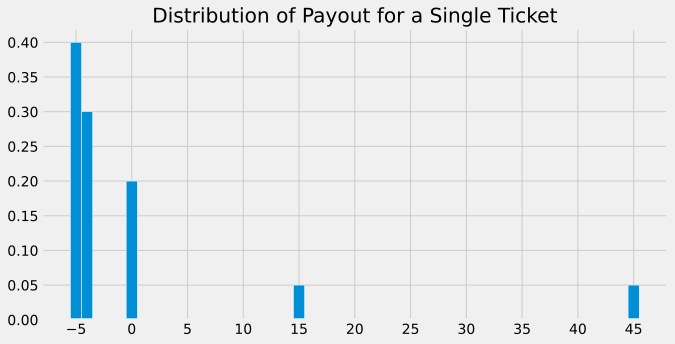

In [47]:
plt.figure(figsize=(10, 5))
plt.bar([-5, -4, 0, 15, 45], [0.4, 0.3, 0.2, 0.05, 0.05], width=1, ec='w')
plt.xticks(np.arange(-5, 50, 5))
plt.title('Distribution of Payout for a Single Ticket');

Note that using math you will learn in future courses, you can show that the amount you should "expect" to win each time you buy a ticket is -\\$0.20.

### Simulating one lottery ticket

- Choose a payout according to the probability distribution.
    - Payout \\$45 with probability 0.05, \\$15 with probability 0.05, etc.
- `np.random.choice` accepts an array of probabilities.

In [5]:
np.random.choice(lottery.get('Payout'), p=lottery.get('Probability'))

-5

### Simulating 100 tickets

- How much do you win/lose after buying 100 tickets?
- In other words, what are your total winnings?

In [48]:
payouts = np.array(lottery.get('Payout'))
probs = np.array(lottery.get('Probability'))

def buy_k_tickets(k):
    winnings = np.array([])
    
    for i in np.arange(k):
        won = np.random.choice(payouts, p=probs)
        winnings = np.append(winnings, won)
        
    return winnings

In [49]:
buy_k_tickets(100).sum() # A sample sum

67.0

### Repeating the experiment

- After purchasing 100 tickets, your total winnings are a number.
- But each payout was random, and so total winnings are also random, and hence could have been different...
- Total winnings come from some distribution.
    - If we had access to this distribution, we could determine exactly the probability that our total winnings after buying 100 tickets is $X$, for any value of $X$.
- We can approximate this distribution through simulation.

### Repeating the experiment

In [50]:
distribution = np.array([])
n_repetitions = 1000

for i in np.arange(n_repetitions):
    winnings = buy_k_tickets(100).sum()
    distribution = np.append(distribution, winnings)

In [51]:
distribution

array([  72.,  191., -116., ..., -120.,   31.,   25.])

### Visualizing

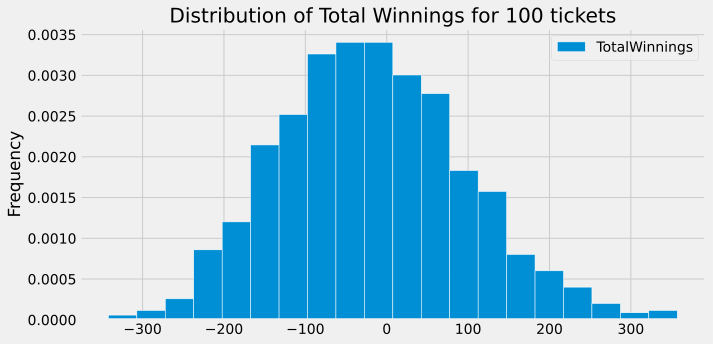

In [52]:
bpd.DataFrame().assign(TotalWinnings=distribution).plot(kind='hist', density=True, bins=20, ec='w',
                                                        title='Distribution of Total Winnings for 100 tickets',
                                                        figsize=(10, 5));

- This looks roughly normal!
- Note that this distribution is centered near -20, which is -0.2 (the amount we expect to win each time individually) * 100 (the number of tickets we purchased).

In [11]:
np.mean(distribution)

-29.372

### You Try

1. Why does the CLT apply for the shape of the total winnings distribution?
1. If we repeated the experiment with 400 tickets instead of 100, how would the mean and SD of the distribution change?
1. Write the code to do the experiment for 400 tickets. Compare the histograms.
1. What if we did 5000 repetitions instead of 1000 repetitions? How would the distribution change?
1. Write the code to do the experiment for 100 tickets and 5000 repetitions. Compare the histograms.

### Answer 

In [12]:
distribution_400 = np.array([])
n_repetitions = 1000

for i in np.arange(n_repetitions):
    winnings = buy_k_tickets(400).sum()
    distribution_400 = np.append(distribution_400, winnings)

In [13]:
distribution_400

array([-299., -346., -309., ..., -240.,  -95.,  -89.])

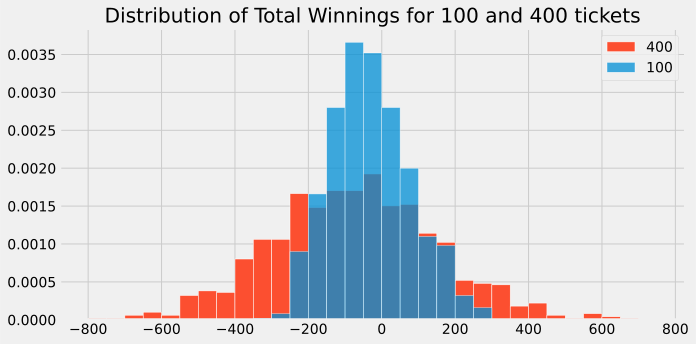

In [14]:
bins = np.arange(-800, 800, 50)
plt.figure(figsize=(10, 5))
plt.hist(distribution_400, color='C1', bins=bins, density=True, ec='w', label='400');
plt.hist(distribution, bins=bins, density=True, alpha=.75, ec='w', label='100');
plt.title('Distribution of Total Winnings for 100 and 400 tickets')
plt.legend();

- Note that we're looking at the distribution of sample sums, not sample means.
- When buying 400 tickets, we can win more AND lose more than we could when just buying 100 tickets.

In [15]:
# Close to -0.2 * 400
np.mean(distribution_400)

-76.289

### Increasing repetitions

In [53]:
distribution_5k = np.array([])
n_repetitions = 5000

for i in np.arange(n_repetitions):
    winnings = buy_k_tickets(100).sum()
    distribution_5k = np.append(distribution_5k, winnings)

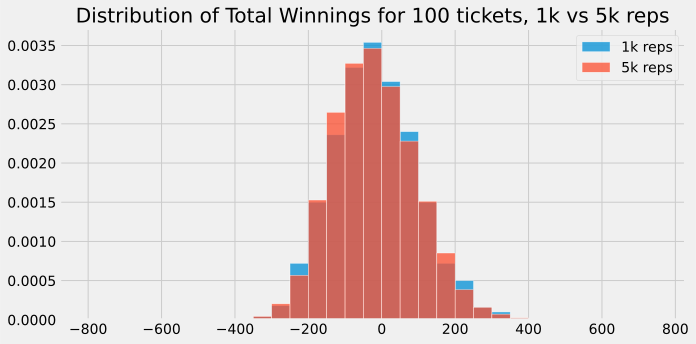

In [54]:
bins = np.arange(-800, 800, 50)
plt.figure(figsize=(10, 5))
plt.hist(distribution, bins=bins, density=True, alpha=.75, ec='w', label='1k reps');
plt.hist(distribution_5k, bins=bins, density=True, alpha=.75, ec='w', label='5k reps');
plt.title('Distribution of Total Winnings for 100 tickets, 1k vs 5k reps')
plt.legend();

### Example: flight delays

In [55]:
flights = bpd.read_csv('data/united_summer2015.csv').get(['Delay'])

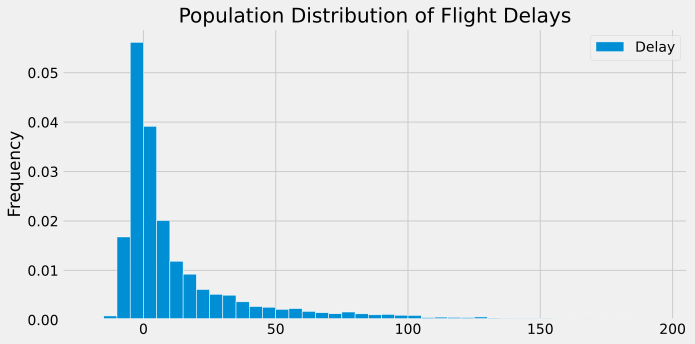

In [56]:
flights.plot(kind='hist', y='Delay', bins=np.arange(-20, 200, 5), density=True, ec='w', figsize=(10, 5), title='Population Distribution of Flight Delays');

Note that the population mean is around 16.66.

In [57]:
pop_mean = flights.get('Delay').mean()
pop_mean

16.658155515370705

What happens if we repeatedly sample from the population and compute the mean?

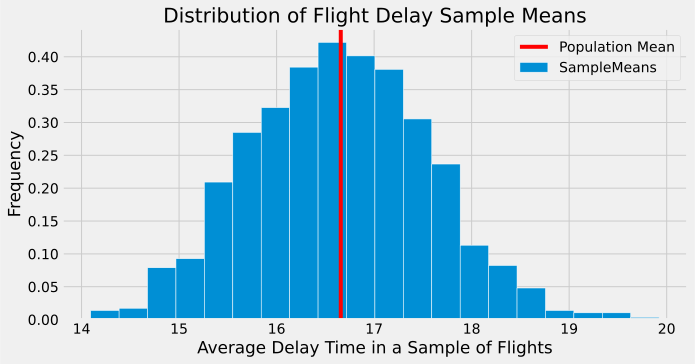

In [58]:
n_samples = 1000

sample_means = np.array([])

for i in np.arange(n_samples):
    sample = flights.sample(2000, replace=True)
    sample_mean = sample.get('Delay').mean()
    sample_means = np.append(sample_means, sample_mean)
    
bpd.DataFrame().assign(SampleMeans=sample_means).plot(kind='hist', bins=20, density=True, 
                                                      ec='w', figsize=(10, 5), title='Distribution of Flight Delay Sample Means');
plt.xlabel('Average Delay Time in a Sample of Flights')
plt.axvline(pop_mean, color='red', label='Population Mean')
plt.legend();

### Shape, center, and spread of the distribution of sample mean

- The CLT says that the distribution of the means of random samples is roughly normal, no matter what the population looks like.
- This distribution is centered at the population mean.
- What is the spread of the distribution of the sample mean?

The function `sample_mean_delays` takes a sample of size `sample_size`, computes the mean of that sample, and repeats this process `n_samples` times.

In [59]:
def sample_mean_delays(sample_size, n_samples=2000):
    sample_means = np.array([])
    for i in np.arange(n_samples):
        sample = flights.sample(sample_size)
        sample_mean = sample.get('Delay').mean()
        sample_means = np.append(sample_means, sample_mean)
    return sample_means

Let's repeat our experiment using many different sample sizes.

In [62]:
sample_means = {}
sample_sizes = [1, 5, 10, 50, 100, 200, 400, 800, 1600]

for size in sample_sizes:
    sample_means[size] = sample_mean_delays(size)

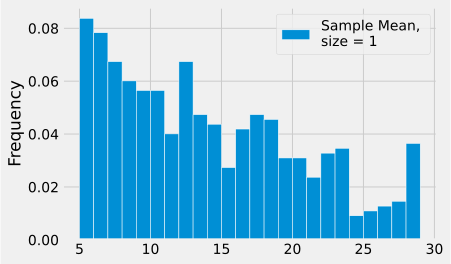

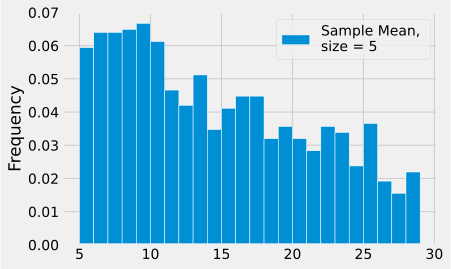

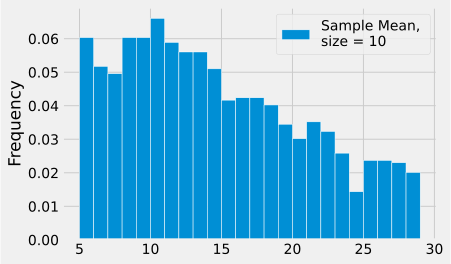

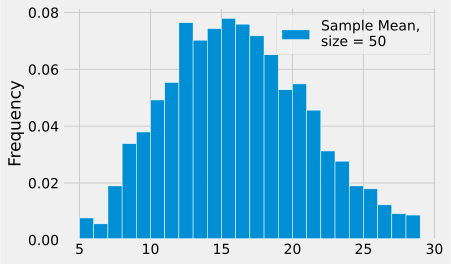

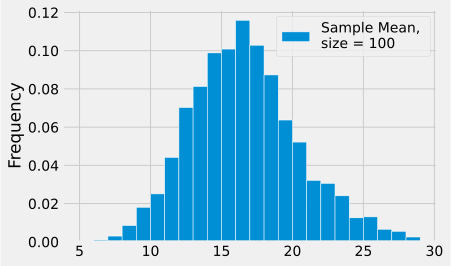

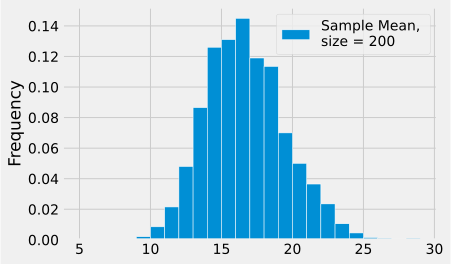

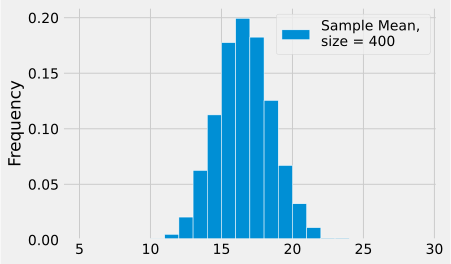

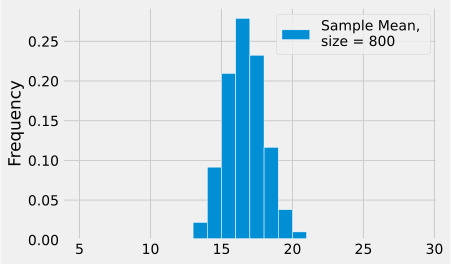

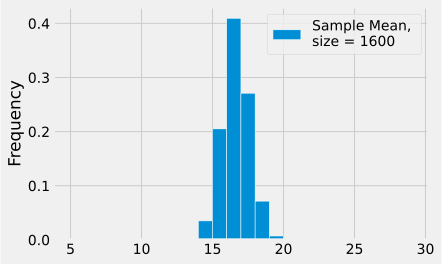

In [63]:
# Plot the resulting distributions
bins = np.arange(5, 30)
for size in sample_sizes:
    columns = {f'Sample Mean, \nsize = {size}': sample_means[size]}
    bpd.DataFrame().assign(**columns).plot(kind='hist', bins=bins, density=True, ec='w');

What do you notice? 🤔

### Spread of the sample mean's distribution

- As we increase our sample size, the spread of the sample mean's distribution decreases.
- Can we determine exactly how much it decreases by?

In [23]:
# Compute the standard deviation of each distribution
sds = np.array([])
for size in sample_sizes:
    sd = np.std(sample_means[size])
    sds = np.append(sds, sd)
    
sds

array([3.98, 2.79, 1.95, 1.34, 0.93])

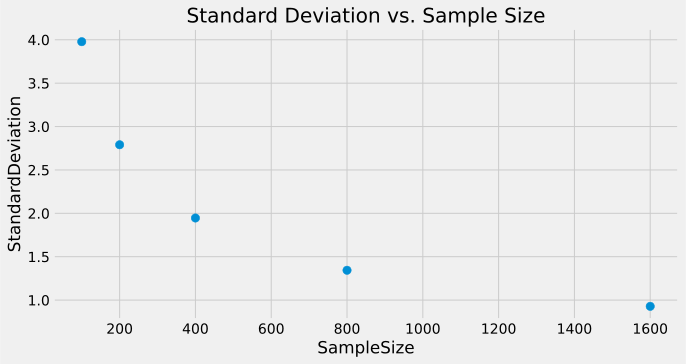

In [24]:
observed = bpd.DataFrame().assign(
    SampleSize=sample_sizes,
    StandardDeviation=sds
)

observed.plot(kind='scatter', x='SampleSize', y='StandardDeviation', s=70, title='Standard Deviation vs. Sample Size', figsize=(10, 5));

### CLT for the sample mean

- The distribution of the sample mean of random samples is roughly normal.
- It is centered at the population mean.
- Its standard deviation is:
$$\text{SD of Distribution of Possible Sample Means} = \frac{\text{Population SD}}{\sqrt{\text{sample size}}}$$

- This is sometimes called the **square root law**.

- **Note:** this is **not** saying anything about the standard deviation of a sample itself! It is a statement about the distribution of all possible sample means. As sample size goes up...
    - ❌ My sample's SD goes down (not true).
    - ✅ The SD of the bootstrap distribution goes down (true).

Let's see how well this formula works in action. `clt_standard_deviation` computes the SD of the sample mean distribution for any sample size.

In [25]:
def clt_standard_deviation(n):
    pop_sd = np.std(flights.get('Delay'))
    return pop_sd / np.sqrt(n)

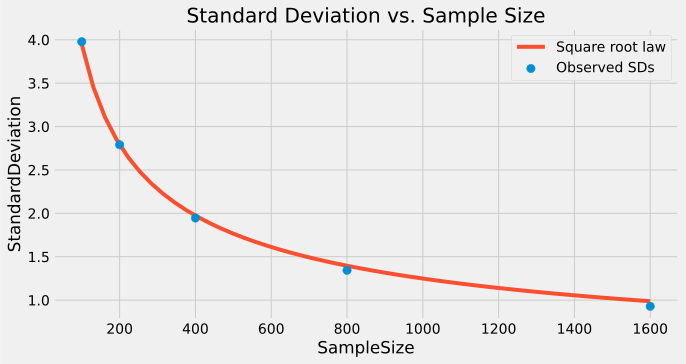

In [26]:
observed.plot(kind='scatter', x='SampleSize', y='StandardDeviation', s=70, zorder=10, title='Standard Deviation vs. Sample Size', figsize=(10, 5), label='Observed SDs');
x = np.linspace(100, 1600)
y = clt_standard_deviation(x)
plt.plot(x, y, color='C1', label='Square root law')
plt.legend();

### Recap: The Central Limit Theorem

Suppose we draw a sample of 500 flights and find the mean flight delay.

There are three distributions involved:

- The population (we don't see this).
- The sample (we see this).
- Distribution of the sample mean (we don't see this directly, because we only collected one sample).
    - a.k.a, sampling distribution of the mean.
    - a.k.a, empirical distribution of the sample mean.
    - So far, we've used the bootstrap to approximate this.

In [27]:
show_clt_slides()

### The population (we don't see this)

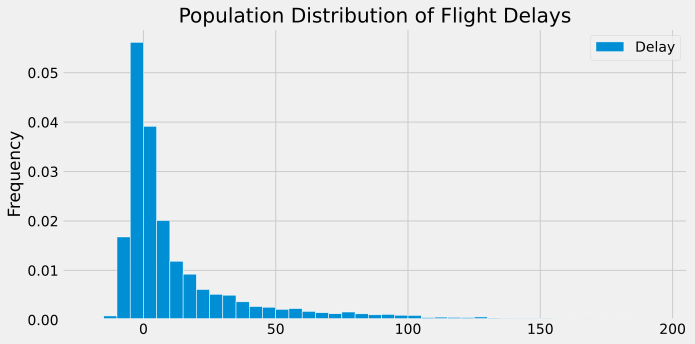

In [28]:
flights.plot(kind='hist', y='Delay', bins=np.arange(-20, 200, 5), density=True, ec='w', figsize=(10, 5), title='Population Distribution of Flight Delays');

### The population

- We don't see:
    - the population distribution,
    - the population mean (fixed!),
    - the population standard deviation (fixed!).
- CLT doesn't say anything about this distribution.

### The sample

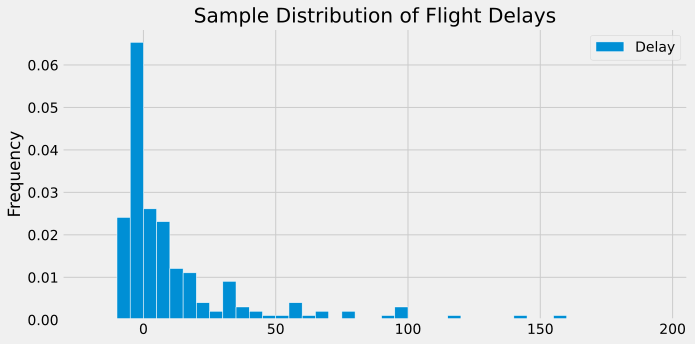

In [29]:
flights.sample(200).plot(kind='hist', y='Delay', bins=np.arange(-20, 200, 5), density=True, ec='w', figsize=(10, 5), title='Sample Distribution of Flight Delays');

### The sample

- We *do* see (or can calculate):
    - the sample itself (random!),
    - the sample's mean (random!),
    - the sample's standard deviation (random!).
- CLT doesn't say anything about this distribution, either.

### Distribution of the sample mean

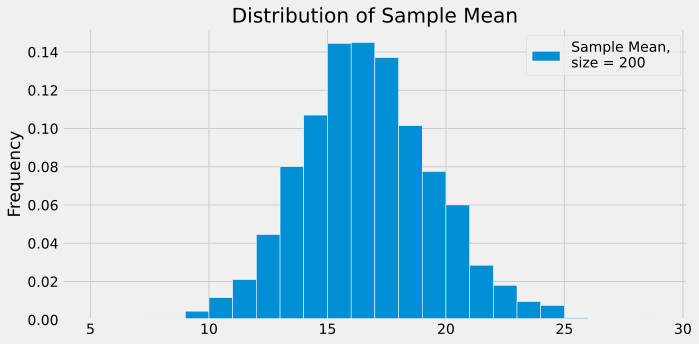

In [30]:
bins = np.arange(5, 30)
columns = {f'Sample Mean, \nsize = {200}': sample_means[200]}
bpd.DataFrame().assign(**columns).plot(kind='hist', bins=bins, density=True, ec='w', figsize=(10, 5), title='Distribution of Sample Mean');

### Distribution of the sample mean

- The distribution of the sample mean is roughly normal.
- It is centered at population mean (fixed, unobserved).
- Its standard deviation (fixed, unobserved):
$$ \text{SD of Distribution of Possible Sample Means} = \frac{\text{Population SD}}{\sqrt{\text{sample size}}}$$
- **This** is the distribution that the CLT is talking about.

## Confidence intervals

### Confidence intervals

- Previously, we bootstrapped to construct confidence intervals.
    - Strategy: collect one sample, repeatedly resample from it, calculate the statistic on each resample, and look at middle 95% of resampled statistics.
- But, **if our statistic is the mean**, we can use the CLT.
    - Computationally cheaper - no simulation required!
- In both cases, we use just a single sample to construct our confidence interval.

### Collect a single sample and run the bootstrap

In [31]:
np.random.seed(23) # Ignore

my_sample = flights.sample(400) # Only collecting one sample!
my_sample_mean = my_sample.get('Delay').mean()
my_sample_mean

14.31

In [32]:
n_boot = 5000
np.random.seed(4)
boot_means = np.array([])

for i in np.arange(n_boot):
    resample = my_sample.sample(my_sample.shape[0], replace=True)
    boot_mean = resample.get('Delay').mean()
    boot_means = np.append(boot_means, boot_mean)

In [33]:
boot_means

array([13.84, 11.88, 12.38, ..., 12.51, 13.91, 11.49])

### Visualize the bootstrap

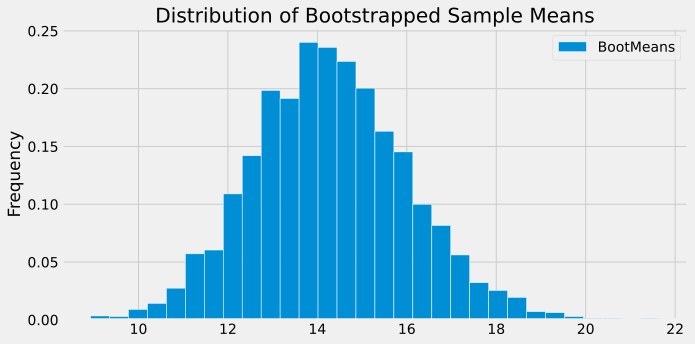

In [34]:
bpd.DataFrame().assign(BootMeans=boot_means).plot(kind='hist', y='BootMeans', bins=30, density=True, ec='w', figsize=(10, 5), title='Distribution of Bootstrapped Sample Means');

- Note that this distribution is centered on the sample mean, not the population mean.
    - Remember, we repeatedly resampled from the original sample, not the population.

In [35]:
pop_mean

16.658155515370705

In [36]:
my_sample_mean

14.31

### Construct a 95% confidence interval

In [37]:
left_boot = np.percentile(boot_means, 2.5)
right_boot = np.percentile(boot_means, 97.5)
[left_boot, right_boot]

[11.0675, 17.937624999999997]

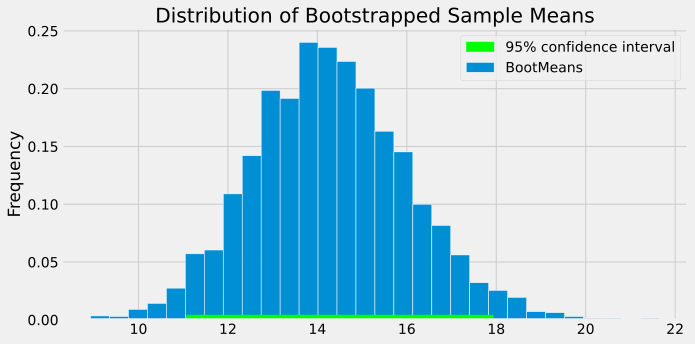

In [38]:
bpd.DataFrame().assign(BootMeans=boot_means).plot(kind='hist', y='BootMeans', bins=30, density=True, ec='w', figsize=(10, 5), title='Distribution of Bootstrapped Sample Means');
plt.plot([left_boot, right_boot], [0, 0], color='lime', linewidth=10, label='95% confidence interval');
plt.legend();

### What was the point of bootstrapping?

- We bootstrapped to approximate the distribution of the sample mean.
    - *How might the sample mean have been different if we'd collected a different sample?*
- But the CLT tells us it is approximately normal!
- We can use the CLT directly to construct CIs.

### A new approach to confidence intervals for population means

- We know that the distribution of the sample mean is roughly normal.
- This distribution is centered at the population mean.
- The SD of the sample mean's distribution is
$$\text{SD of Distribution of Possible Sample Means} = \frac{\text{Population SD}}{\sqrt{\text{sample size}}}$$
- Another issue is that we don't know the population's SD. Instead, we can use the sample's SD:
$$\text{SD of Distribution of Possible Sample Means} \approx \frac{\text{Sample SD}}{\sqrt{\text{sample size}}}$$

### The normal curve

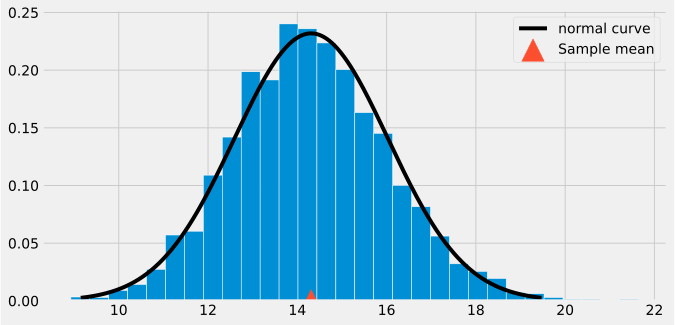

In [39]:
# Draw the normal curve
from scipy import stats
my_sample_std = np.std(my_sample.get('Delay'))
x = np.linspace(my_sample_mean - 3 * my_sample_std / 20, my_sample_mean + 3 * my_sample_std / 20, 1000)
y = stats.norm.pdf(x, my_sample_mean, my_sample_std / 20)

plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', linestyle='-', label='normal curve')
plt.scatter(my_sample_mean, 0, marker='^', color='C1', s=500, label='Sample mean', zorder=2)
plt.legend(loc='upper right')
plt.hist(boot_means, density=True, bins=30, ec='w');

- Note that this normal curve isn't the "standard normal".
     - It has a mean other than 0 and standard deviation other than 1.
- But most of the properties we looked at before still apply.

### Recall: proportion within $z$ SDs of the mean

|Percent in Range | All Distributions (via Chebyshev's Inequality) | Normal Distributions|
|---|---|---|
|$\text{average} \pm 1 \ \text{SD}$ | $\geq 0\%$ | $\approx 68\%$ |
|$\text{average} \pm 2\text{SDs}$ | $\geq 75\%$ | $\approx 95\%$ |
|$\text{average} \pm 3\text{SDs}$ | $\geq 88\%$ | $\approx 99.73\%$ |

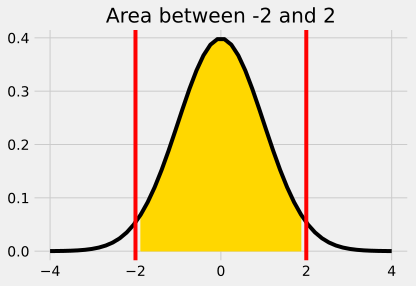

In [40]:
normal_area(-2, 2, bars=True)

### Computing a 95% confidence interval

- Recall: Approximately 95% of the normal curve's area falls within $\pm$ 2 SDs of the mean.
- Don't confuse the **sample SD** with the **SD of the sample mean's distribution**!

$$\text{SD of Distribution of Possible Sample Means} \approx \frac{\text{Sample SD}}{\sqrt{\text{sample size}}}$$

### You Try:

Create a 95% confidence interval for the mean flight delay using the CLT.

1. Estimate the SD for the bootstrap distribution using the square root law.
1. Find the left and right endpoints of the CI using the formula: $\text{average} \pm 2\text{SDs}$.
1. Compare the CI with the bootstrap CI.

In [41]:
left_normal = my_sample_mean - 2 * my_sample_std / np.sqrt(400)
right_normal = my_sample_mean + 2 * my_sample_std / np.sqrt(400)
[left_normal, right_normal]

[10.869267665161964, 17.750732334838037]

### Visualizing this confidence interval

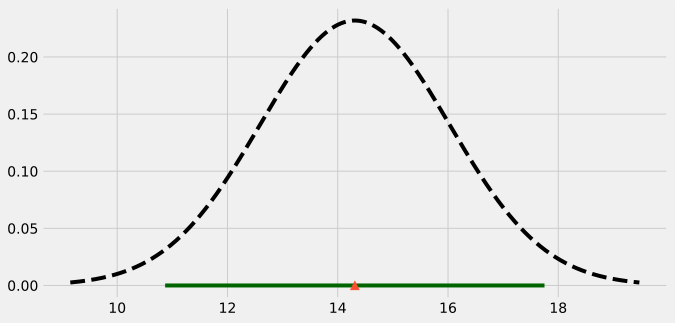

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], color='darkgreen', zorder=1)
plt.scatter(my_sample_mean, 0, marker='^', color='C1', zorder=2, s=80);

### CLT-based confidence interval vs. bootstrap-based confidence interval

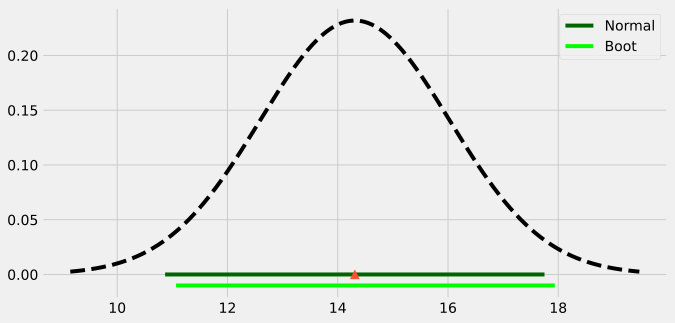

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], color='darkgreen', zorder=1, label='Normal')
plt.plot([left_boot, right_boot], [-.01, -.01], color='lime', label='Boot')
plt.scatter(my_sample_mean, 0, marker='^', color='C1', zorder=2, s=80)
plt.legend();

- They're pretty similar!
- But the only information the CLT-based confidence interval used was the sample mean (1 number), sample standard deviation (1 number), and sample size (1 number).

### Recap: confidence intervals for population means

An approximate 95% confidence interval for the population mean is given by

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{n}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{n}}
\right]
$$

### So... why do we ever need to bootstrap?

- We can use the CLT to make CIs using sample means (and, as a result, sample proportions).
- But applying the CLT for e.g. the median is hard...
- As a result, we use bootstrap to find a CI for the median.
- In practice, the bootstrap works better when the bootstrap distribution is skewed.

## Why does it matter?

- CLT is very useful!
    - But it doesn't say *how* big samples need to be.
    - Still need to visualize distribution.
- You'll see normal theory CIs all the time in practice.
- **Next time:** experiment design.
    - How large of a sample should we collect? 🤔